# Practical Exercise: Search Engines for Multimedias
## Part 2: Implementing our own descriptors
The objective of this notebook is to use the clusters furnished and the K-Means algorithm so we can group the descriptors of each image, and then apply the Bow and VLAD classification.

The libraries utilised for this Practical Exercise are given bellow.

In [1]:
import numpy as np
import pandas as pd
import time
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import average_precision_score
import scipy.spatial.distance as distance
import matplotlib.pyplot as plt

Here we take some functions developed in Part 1. Further information about them can be found in the previous Part.

In [2]:
def getListOfSimilarImages(request, database):
    distances = distance.cdist(request[None, :], 
                               np.asmatrix(database), 
                               metric='euclidean').transpose()
    distances = pd.DataFrame(distances)
    distances = distances.sort_values(distances.columns[0])
    return distances.index

def getAllSimilar(database, indexes):
    distances = []
    for i in range(len(indexes)):
        distances.append(getListOfSimilarImages(database[indexes[i]],
                                           database))
    return np.array(distances)

def AP(y_true, d_pred):
    Nc = np.sum(y_true)
    ap = 0
    true = np.where(y_true)
    positions = np.where(np.in1d(d_pred, true))[0]
    for i in range(Nc):
        ap += (i + 1) / (positions[i] + 1)
    if(Nc == 0):
        return 0
    ap /= Nc
    return ap

def MAP(y_true, d_pred):
    MAP = 0
    for i in range(len(y_true)):
        MAP += AP(y_true[i], d_pred[i])
    return MAP / len(y_true)

def getTruthMatrix(requests, results, Nc):
    true_vals = []
    for j in range(len(requests)):
        y_true = np.zeros(results.shape[0], dtype=bool)
        pred_v = np.zeros(results.shape[0], dtype=bool)
        if(j != 0):
            y_true[requests[j]:Nc[j]+requests[j]] = True
        else:
            y_true[requests[j]:Nc[j]+requests[j]+1] = True
        y_true.astype(bool)
        true_vals.append(y_true)
    return true_vals

Here we retrieve the images 1 to 257 from the original database. There are 1491 in total, by my computer did not have memory enough to store all descriptors.

In [3]:
database = []
for image in range(1, 257):
    descriptor = np.loadtxt("../data/sifts/sift1to256/im" + str(image) + ".txt")
    database.append(descriptor)

In the cell bellow we get all clusters and requests, as we did in the previous Part.

In [4]:
f = open("../data/data_idx.txt", "r")
clusters = [int(x) for x in f.readline().split()]
clusters = np.asarray(clusters)
image_cluster = pd.DataFrame(clusters)
clusters, requests, Nc = np.unique(clusters, return_index=True,
                                      return_counts=True)
requests = requests[requests < 256]
Nc = Nc[:len(requests)]

The function bellow retrieves all the centroids for a certain cluster size. 

In [5]:
def getCentroids(cluster):
    f = open("../data/centroids/K" + str(cluster) + ".txt", "r")
    matrix = []
    for line in f:
        vector = [float(x) for x in line.split()]
        matrix.append(vector)
    k_matrix = np.asmatrix(matrix)
    return pd.DataFrame(k_matrix)

Here we get all clusters in the _data/centroids_ folder. It starts in k = 8 ($2^3$) and finishes at k = 2048 ($2^{11}$).

In [6]:
clusters = []
for i in np.logspace(3, 11, num=9, base=2):
    clusters.append(getCentroids(int(i)))

The clustering function applies the K-Means algorithm from SKLearn to the chosen database, given a certain number of clusters.

In [7]:
def clustering(database, clusters):
    K = clusters.shape[0]
    kmeans_model = KMeans(n_clusters=K)
    kmeans_model.cluster_centers_ = clusters
    results = []
    for request in database:
        results.append(kmeans_model.predict(request))
    return results

clustered = clustering(database, clusters[0]) #k = 8
print(clustered[0])

[2 2 2 ... 1 1 1]


The __BoW__ function takes the descriptors that are assigned to the clusters ( _clustered_ ) and the total number of clusters. It returns a matrix $N_{images} \times N_{clusters}$.

In [8]:
def BoW(clustered, n_clusters):
    results = []
    for request in clustered:
        c = [np.count_nonzero(request == i) for i in range(n_clusters)]
        results.append(c)
    return np.array(results)

Here we calculate de MAP of the BoW descriptor using 8 clusters. It has a smaller precision when compared to the previous Part. On may assume that it is caused by the reduced number of images analysed.

In [20]:
### Testing MAP of BoW
bow = BoW(clustered, 8)
results = getAllSimilar(bow, requests)
true_vals = getTruthMatrix(requests, results, Nc)
val = MAP(true_vals, results)
print("MAP for BOW : " + str(val))

MAP for BOW : 0.19549930019586784


Here we implement the __VLAD__ function. It takes the whole database, the clusters used in the KMeans algorithm, and the relation between the clusters and each request. It returns a matrix $N_{images} \times 128 N_{clusters}$.

In [12]:
def VLAD(database, clusters, clustereds):
    vlad = []
    for request, clustered in zip(database, clustereds):
        v_request = []
        for c in range(clusters.shape[0]):
            v = 0
            nn = request[clustered == c]
            stack = np.tile(clusters.values[c], (nn.shape[0], 1))
            v += np.sum(nn - stack, 0)
            v_request.append(v)
        vlad.append(np.array(v_request).flatten())
    return normalize(np.array(vlad), norm="l2")

In the two cells bellow we calculate the MAP for VLAD descriptors based on a 64-cluster KMeans.

In [13]:
clustered = clustering(database, clusters[2]) #k=64
vlad = VLAD(database, clusters[2], clustered)

In [14]:
### Testing MAP of VLAD
results = getAllSimilar(vlad, requests)
true_vals = getTruthMatrix(requests, results, Nc)
val = MAP(true_vals, results)
print("MAP for VLAD : " + str(val))

MAP for VLAD : 0.2993765529075007


In the loop bellow we collect the MAP results for all sizes of clusters, both for VLAD and BoW descriptors.

In [15]:
MAP_VLAD = []
MAP_BOW  = []
k        = []
for cluster in clusters:
    clustered = clustering(database, cluster)
    
    ### Testing MAP of BoW
    bow = BoW(clustered, cluster.shape[0])
    results = getAllSimilar(bow, requests)
    true_vals = getTruthMatrix(requests, results, Nc)
    val = MAP(true_vals, results)
    MAP_BOW.append(val)
    
    ### Testing MAP of VLAD
    vlad = VLAD(database, cluster, clustered)
    results = getAllSimilar(vlad, requests)
    true_vals = getTruthMatrix(requests, results, Nc)
    val = MAP(true_vals, results)
    MAP_VLAD.append(val)
    
    k.append(cluster.shape[0])

In the plot bellow, we compare the performance of BoW and VLAD.

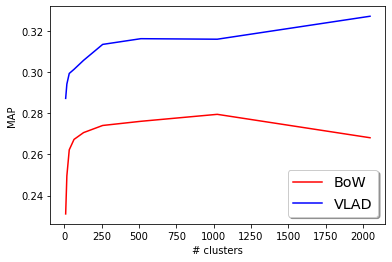

In [18]:
fig, ax = plt.subplots()
ax.plot(k, MAP_BOW, 'r', label="BoW")
ax.plot(k, MAP_VLAD, 'b', label="VLAD")
ax.set_ylabel("MAP")
ax.set_xlabel("# clusters")
legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
plt.show()